In [125]:
import numpy as np 
import pandas as pd
from pandas import DataFrame as df
import datetime
pd.set_option('display.max_columns', 500)
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
rc('font', family='AppleGothic')

In [2]:
master_data = pd.read_stata("masterfile_seoul0205.dta")

In [41]:
master_data['date'] = pd.to_datetime(master_data['REPORTINGMONTH'])
master_data['year'] = master_data['date'].dt.year
master_data['month'] = master_data['date'].dt.month
master_data['yyyymm'] = master_data['year']*100 + master_data['month']

## 0. Data Check

### shape of data

In [3]:
master_data.shape

(231589, 46)

<pre>
2018년 4월까지 서울시에 한번이라도 등록된 적이 있는 airbnb listing의 수는 32,275개.
이 중, 
- 월별 성과 자료와 엮이지 않는 listing
- 월별 성과 자료와 엮였으나, 월별 가격 정보가 나타나 있지 않은 listing
을 제하면, 남는 unique airbnb listing 수는 26,538개

26,528개의 unique listings
231,589개의 panel observations
</pre>

### columns information

In [4]:
master_data.columns

Index(['PROPERTYID', 'HOSTID', 'PROPERTYTYPE', 'LISTINGTYPE', 'BEDROOMS',
       'REPORTINGMONTH', 'OCCUPANCYRATE', 'REVENUEUSD', 'REVENUENATIVE',
       'ADRUSD', 'ADRNATIVE', 'NUMBEROFRESERVATIONS', 'RESERVATIONDAYS',
       'AVAILABLEDAYS', 'BLOCKEDDAYS', 'COUNTRY', 'CITY', 'NEIGHBORHOOD',
       'LATITUDE', 'LONGITUDE', 'ACTIVE', 'SCRAPEDDURINGMONTH',
       'CURRENCYNATIVE', 'NUMBEROFREVIEWS', 'BATHROOMS', 'MAXGUESTS',
       'RESPONSERATE', 'RESPONSETIMEMIN', 'SUPERHOST', 'CANCELLATIONPOLICY',
       'SECURITYDEPOSITUSD', 'SECURITYDEPOSITNATIVE', 'CLEANINGFEEUSD',
       'CLEANINGFEENATIVE', 'EXTRAPEOPLEFEEUSD', 'EXTRAPEOPLEFEENATIVE',
       'CHECKINTIME', 'CHECKOUTTIME', 'MINIMUMSTAY', 'NUMBEROFPHOTOS',
       'BUSINESSREADY', 'INSTANTBOOKENABLED', 'OVERALLRATING', 'adm_cd', 'gu',
       'dong'],
      dtype='object')

<pre>
성과관련 변수 
'OCCUPANCYRATE', 'REVENUEUSD', 'REVENUENATIVE',
'ADRUSD', 'ADRNATIVE', 'NUMBEROFRESERVATIONS', 'RESERVATIONDAYS',
'AVAILABLEDAYS', 'BLOCKEDDAYS'

건물 종류 관련 변수
'PROPERTYTYPE', 'LISTINGTYPE'

listing 특성 변수
'BEDROOMS', 'BATHROOMS', 'MAXGUESTS', 'CLEANINGFEEUSD', 'EXTRAPEOPLEFEEUSD'
'CHECKINTIME', 'CHECKOUTTIME', 'MINIMUMSTAY', 'NUMBEROFPHOTOS', 'BUSINESSREADY', 'INSTANTBOOKENABLED'
</pre>

### sum stat w/ outlier

In [7]:
performance = master_data[['OCCUPANCYRATE', 'REVENUEUSD', 'ADRUSD', 'RESERVATIONDAYS', 'AVAILABLEDAYS', 'BLOCKEDDAYS']]
performance.describe()

,OCCUPANCYRATE,REVENUEUSD,ADRUSD,RESERVATIONDAYS,AVAILABLEDAYS,BLOCKEDDAYS
count,231589.000000,231589.000000,231589.000000,231589.000000,231589.000000,231589.000000
mean,0.531393,981.703979,72.464882,13.950542,12.819167,3.657117
std,0.314597,1831.971069,199.415329,9.121760,9.298525,6.281543
min,0.032000,8.000000,6.000000,1.000000,0.000000,0.000000
25%,0.233000,277.000000,39.000000,6.000000,5.000000,0.000000
50%,0.548000,711.799988,60.430000,13.000000,11.000000,0.000000
75%,0.815000,1409.000000,82.290001,22.000000,21.000000,5.000000
max,1.000000,555119.000000,61679.898438,31.000000,30.000000,30.000000


<pre>
"변수명" : "변수 설명(airdna 회사에서 준 설명 복붙)"
--------------------------------------------------------------------------------------------------------------
"Occupancy Rate" : Count of Reservation Days / (Count of Reservation Days + Count of Available Days)
"Revenue USD" : Total monthly listing revenue in USD. <b>Includes cleaning fees</b> but not other additional fees
"ADRUSD" : Average Booked Daily Rate in USD. <b>Includes cleaning fee</b>, but not other charges
"RESERVATIONDAYS" : Count of days with a reservation in the month
"AVAILABLEDAYS" : Count of days with a reservation in the month
"BLOCKEDDAYS" : Count of days blocked from accepting reservations in the month
--------------------------------------------------------------------------------------------------------------


전체의 평균이지만, 
listing들이 평균적으로 한달에 26~27일을 72달러 가격에 숙소 등록을 해두고, 
그 중에서 절반정도(53%)인 14일 예약이 되어, 981달러 정도 수익을 올림

max 값을 보면 지나치게 높은 월별 수익을 보인 observation이 있음.
--> 월별 수익이 10,000 달러가 넘어가면 outlier로 생각하고 outlier를 제거하고 sum stat 다시 확인
</pre>

### sum state w/o outlier

In [9]:
performance_no_outlier = performance.query("REVENUEUSD < 10000")
performance_no_outlier.describe()

,OCCUPANCYRATE,REVENUEUSD,ADRUSD,RESERVATIONDAYS,AVAILABLEDAYS,BLOCKEDDAYS
count,231462.000000,231462.000000,231462.000000,231462.000000,231462.000000,231462.000000
mean,0.531243,967.030212,71.274300,13.945382,12.823098,3.658277
std,0.314608,944.957031,57.893543,9.120346,9.298512,6.282550
min,0.032000,8.000000,6.000000,1.000000,0.000000,0.000000
25%,0.233000,277.000000,39.000000,6.000000,5.000000,0.000000
50%,0.548000,711.000000,60.400002,13.000000,11.000000,0.000000
75%,0.815000,1407.400024,82.227503,22.000000,21.000000,5.000000
max,1.000000,9920.000000,2760.000000,31.000000,30.000000,30.000000


## location of high quantile and low qunatile wrt revenue </br>
전체 observatoin 기준으로 구분한 qunatile 이기 때문에, unique listing 숫자는 서로 다를 수 있음. </br>
개략적인 위치를 확인하기 위한 과정

In [22]:
performance_low = master_data.query("REVENUEUSD <= 277")
performance_high = master_data.query("REVENUEUSD >= 1407")
performance_low = performance_low.drop_duplicates(['PROPERTYID'])
performance_high = performance_high.drop_duplicates(['PROPERTYID'])
performance_low = performance_low[['PROPERTYID','LATITUDE', 'LONGITUDE']]
performance_high = performance_high[['PROPERTYID','LATITUDE', 'LONGITUDE']]

In [34]:
map_high = folium.Map(location=[37.538801, 127.004746], tiles='cartodbpositron')
map_low = folium.Map(location=[37.538801, 127.004746], tiles='cartodbpositron')

Lat_high = list(performance_high['LATITUDE'])
Longt_high = list(performance_high['LONGITUDE'])
for i in range(len(Lat_high)):
    folium.CircleMarker([Lat_high[i],Longt_high[i]],radius=0.5,color='#335EFF',fill_color='#335EFF').add_to(map_high)

Lat_low = list(performance_low['LATITUDE'])
Longt_low = list(performance_low['LONGITUDE'])
for i in range(len(Lat_low)):
    folium.CircleMarker([Lat_low[i],Longt_low[i]],radius=0.5,color='#ff0000',fill_color='#ff0000').add_to(map_low)    

In [35]:
map_low.save('low.html')
map_high.save('high.html')

### low quantiles' locations

In [36]:
from IPython.display import IFrame
IFrame(src='low.html', width=700, height=600)

### high quantiles' locations

In [37]:
IFrame(src='high.html', width=700, height=600)

<pre>
수익이 좋은 곳중 의외로 도심에서 벗어나 있는 곳들도 있고, 
수익이 나쁜 곳이라고 해서 도심에 없는 것이 아니다.
홍대, 공덕, 이태원, 명동, 동대문, 강남 지역에 listing이 대부분 모여 있음을 확인 할 수 있음.
지역(구/동)별로 세세하게 나누어 확인을 해볼 필요가 있다. 

1. 자료를 구 단위로 collapse하여, revenue 기준 상위 5개 구를 뽑아내고, 
2. 해당 구들의 자료를 yyyymm에 따라 plot한 뒤, 
3. 구 내의, 동별 차이, 건물종별 차이 확인 <b>(NOT YET)</b>

</pre>

## 1. 구 level에서 check

In [44]:
def calculator(data):
    d = {}
    d['OCCUPANCYRATE'] = data['OCCUPANCYRATE'].mean()  # Occupancy Rate
    d['REVENUEUSD'] = data['REVENUEUSD'].mean()
    d['ADRUSD'] = data['ADRUSD'].mean()
    d['RESERVATIONDAYS'] = data['RESERVATIONDAYS'].mean()
    d['AVAILABLEDAYS'] = data['AVAILABLEDAYS'].mean()
    d['BLOCKEDDAYS'] = data['BLOCKEDDAYS'].mean()
    return pd.Series(d, index=['OCCUPANCYRATE', 'REVENUEUSD', 'ADRUSD', 'RESERVATIONDAYS', 'AVAILABLEDAYS', 'BLOCKEDDAYS'])

In [133]:
GU = master_data.groupby(['gu']).apply(calculator)
GU_mm = master_data.groupby(['gu', 'yyyymm']).apply(calculator)

In [78]:
GU.sort_values(by='REVENUEUSD', ascending = False)

,OCCUPANCYRATE,REVENUEUSD,ADRUSD,RESERVATIONDAYS,AVAILABLEDAYS,BLOCKEDDAYS
gu,,,,,,
중구,0.563549,1135.817139,74.709007,15.161656,12.052423,3.208895
강남구,0.536919,1108.071289,88.405937,13.665068,12.415263,4.362553
종로구,0.463502,1040.253662,91.340897,12.364003,14.916260,3.159381
마포구,0.553771,1036.349121,70.126129,14.785539,12.287276,3.347431
용산구,0.518461,948.768921,71.219498,13.667185,13.149742,3.605781
서초구,0.547435,924.943298,69.592491,13.942544,12.109191,4.385862
금천구,0.493033,862.768188,57.836689,13.463576,14.463576,2.503311
영등포구,0.564127,820.597595,60.324402,14.166200,11.643272,4.623681
동대문구,0.532658,797.842285,58.477783,13.713551,12.734624,3.951728


<pre>
구 단위에서 평균을 냈을 때,
Revenue가 높은 순으로 나열한 결과 
중구 > 강남구 > 종로구 > 마포구 > 용산구  순으로 평균 rev가 높게 나타남
</pre>

In [134]:
GU_mm.reset_index(level='gu', inplace=True)
GU_mm.reset_index(level='yyyymm', inplace=True)
GU_mm['year'] = (GU_mm['yyyymm']/100).astype(int)
GU_mm['month'] = GU_mm['yyyymm'] - GU_mm['year']*100
GU_mm['date'] = GU_mm['year'].astype(str) + "-" + GU_mm['month'].astype(str) + "-1"
GU_mm['datetime'] = pd.to_datetime(GU_mm['date'])

In [139]:
A = ['노원구', '도봉구', '관악구', '중랑구', '성북구']
B = ['중구', '강남구', '종로구', '마포구', '용산구']
C = ['노원구', '도봉구', '관악구', '중랑구', '성북구', '강북구','광진구','구로구','강서구', '강동구']
D = ['중구', '강남구', '종로구', '마포구', '용산구', '서초구', '금천구', '영등포구', '동대문구', '송파구']
GU_mm1 = GU_mm.query("gu == @B")
GU_mm2 = GU_mm.query("gu == @A")
GU_mm3 = GU_mm.query("gu == @D")
GU_mm4 = GU_mm.query("gu == @C")

### 수익 상위 5개 구 Revenue Plot

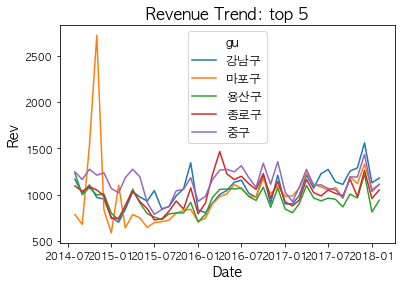

In [137]:
ax = sns.lineplot(x='datetime', y='REVENUEUSD', hue='gu', data = GU_mm1)
plt.title('Revenue Trend: top 5', fontsize=16)
plt.ylabel('Rev', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.show()

### 수익 하위 5개 구 Revenue Plot

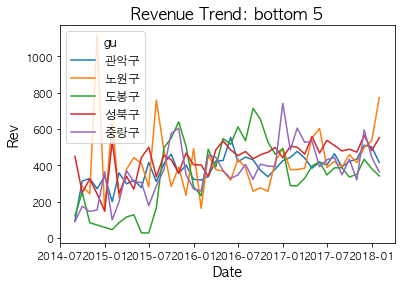

In [138]:
ax = sns.lineplot(x='datetime', y='REVENUEUSD', hue='gu', data = GU_mm2)
plt.title('Revenue Trend: bottom 5', fontsize=16)
plt.ylabel('Rev', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.show()

<pre>
상위 5개 구의 revenue trend는 하위 5개 구의 revenue trend에 비하여 동조화 되어 있음을 확인할 수 있었음.
또한 airbnb의 숫자가 크게 증가한 2015년 이후부터는 굉장히 유사한 트렌드를 보임 
</pre>

### 수익 상위 10개 구 Revenue Plot

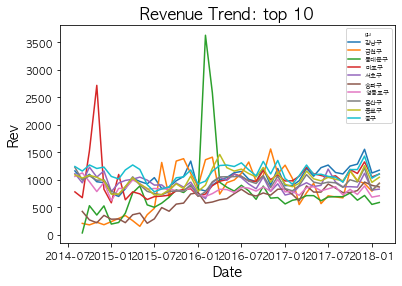

In [143]:
ax = sns.lineplot(x='datetime', y='REVENUEUSD', hue='gu', data = GU_mm3)
plt.title('Revenue Trend: top 10', fontsize=16)
plt.ylabel('Rev', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=6, loc='best')
plt.show()

### 수익 하위 10개 구 Revenue Plot

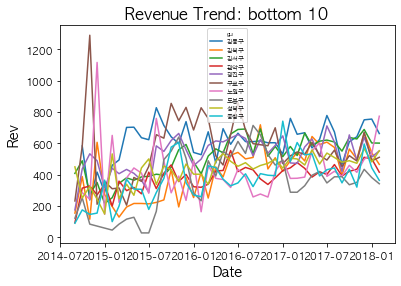

In [144]:
ax = sns.lineplot(x='datetime', y='REVENUEUSD', hue='gu', data = GU_mm4)
plt.title('Revenue Trend: bottom 10', fontsize=16)
plt.ylabel('Rev', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=6, loc='best')
plt.show()

<pre>
상위, 하위 그룹을 5개 -> 10개로 늘려서 확인해 보아도 상위 그룹의 유사한 트렌드 확인 가능
- scale이 달라서 그런 것일 수도.. 확인해봐야함
- outlier에 대한 고려 필요함
</pre>